In [2]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor, hist as chs
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)

/uscms_data/d3/aaportel/mambaforge/envs/analysis-env/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [3]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """
    
    global a # don't do this
    a = 1

    def acc_cut(self, events):

        cut = (events.gLLP_csc == 1)
        return events[cut]
        #return events[ak.any(cut, axis = -1)]

    def met_cut(self, events):
        cut = events.metEENoise >= 30
        return events[cut]

    def csc_eff_cut(self, events):
        
        cut = (events.nCscRechitClusters >= 1)
        return events[cut]

    def muon_veto(self, events):
        
        cut = (events.cscRechitClusterMuonVetoPt < 20)
        return events[ak.any(cut, axis = a)]

    def jet_cut(self, events):
        
        cut = (events.cscRechitClusterJetVetoPt < 10)
        return events[ak.any(cut, axis = a)]

    def time_cut(self, events):

        cut = ((events.cscRechitClusterTimeWeighted <= 12.5)&
               (events.cscRechitClusterTimeWeighted >= -5  ))
        return events[ak.any(cut, axis = a)]

    def ME11_veto(self, events):

        cut = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
               (events.cscRechitClusterNRechitChamberMinus11 <= 0))
        return events[ak.any(cut, axis = a)]


    def ME12_veto(self, events):

        cut = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
               (events.cscRechitClusterNRechitChamberMinus12 <= 0))
        return events[ak.any(cut, axis = a)]


    def re12_cut(self, events):
        
        cut = events.cscRechitCluster_match_RE12_0p4 == 0
        return events[ak.any(cut, axis = a)]

    def mb1_cut(self, events):
        
        cut = events.cscRechitCluster_match_MB1Seg_0p4 == 0
        return events[ak.any(cut, axis = a)]

    def rb1_cut(self, events):
        
        cut = events.cscRechitCluster_match_RB1_0p4 == 0
        return events[ak.any(cut, axis = a)]

    def eta_cut(self, events):
        
        cut = abs(events.gLLP_eta) < 2 
        return events[cut]

    def time_spread_cut(self, events):
    
        cut = events.cscRechitClusterTimeSpreadWeightedAll <= 20
        return events[ak.any(cut, axis = a)]

    def cut_based(self, events):
    
        cut = (((events.cscRechitClusterNStation10 > 1) & (abs(events.cscRechitClusterEta) < 1.9))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))
            )
        return events[ak.any(cut, axis = a)]

    def dphi_cut(self, events):
    
        cut = abs(events.cscRechitClusterMetEENoise_dPhi) < 0.75
        return events[ak.any(cut, axis = a)]

    def nrechits_cut(self, events):

        cut = events.cscRechitClusterSize > 130
        return events[ak.any(cut, axis = a)]


    def muon_cls_deltaR(self, events):
        
        clusts = ak.zip(
            {
                'pt': ak.ones_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'mass': ak.ones_like(events.cscRechitClusterPhi),
                'E': ak.ones_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )

        muoncut = abs(events.lepPdgId) == 13
        muons = ak.zip(
            {
                'pt': events.lepPt[muoncut],
                'phi': events.lepPhi[muoncut],
                'eta': events.lepEta[muoncut],
                'mass': ak.ones_like(events.lepPhi[muoncut]),
                'E': events.lepE[muoncut],
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadcut = ak.max(muons.pt, 1) == muons.pt
        muons = muons[leadcut]
        
        muon_cls_pairs = ak.cartesian({
            "clusts": clusts, 
            "muons": muons
        }, axis = 1, nested = True)
        
        
        deltaR = (muon_cls_pairs.clusts).delta_r(muon_cls_pairs.muons)
        
        return deltaR
    
    def muon_llp_deltaR(self, events):
        
        llps = ak.zip(
            {
                'pt': ak.ones_like(events.gLLP_phi),
                'phi': events.gLLP_phi,
                'eta': events.gLLP_eta,
                'mass': ak.ones_like(events.gLLP_phi),
                'E': ak.ones_like(events.gLLP_phi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )

        muoncut = abs(events.lepPdgId) == 13
        muons = ak.zip(
            {
                'pt': events.lepPt[muoncut],
                'phi': events.lepPhi[muoncut],
                'eta': events.lepEta[muoncut],
                'mass': ak.ones_like(events.lepPhi[muoncut]),
                'E': events.lepE[muoncut],
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadcut = ak.max(muons.pt, axis = 1) == muons.pt
        muons = muons[leadcut]
        
        muon_llp_pairs = ak.cartesian({
            "llps": llps, 
            "muons": muons
        }, axis = 1, nested = True)
        
        
        deltaR = (muon_llp_pairs.llps).delta_r(muon_llp_pairs.muons)
        
        return deltaR
        
    
    
    def process(self, events):

        dataset = events.metadata['dataset']
        sumw = ak.sum(events.weight)

        out = {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
            }
        }
        
        
        
        # cheeky way of sequentially adding cuts to events
        #cuts = [self.acc_cut, self.csc_eff_cut, self.muon_veto, self.jet_cut, self.time_cut, self.ME11_veto, self.ME12_veto, self.re12_cut, self.mb1_cut, self.rb1_cut, self.eta_cut, self.time_spread_cut, self.cut_based, self.dphi_cut, self.nrechits_cut]
        cuts = [self.acc_cut, self.met_cut, self.csc_eff_cut, self.muon_veto, self.jet_cut, self.time_cut, self.ME11_veto, self.ME12_veto, self.re12_cut, self.mb1_cut, self.rb1_cut, self.eta_cut, self.time_spread_cut, self.cut_based, self.dphi_cut, self.nrechits_cut]
        last = events
        out[dataset]['total'] = len(last)
        out[dataset]['total_met'] = hs.Hist.new.Reg(30, 0, 100, name='met', label='MET [GeV]').Double()
        out[dataset]['total_met'].fill(ak.flatten(last.metEENoise, axis=None))
        out[dataset]['total_dphi'] = hs.Hist.new.Reg(30, 0, 5, name='dPhi', label='dPhi').Double()
        out[dataset]['total_dphi'].fill(ak.flatten(abs(last.cscRechitClusterMetEENoise_dPhi), axis=None))
        out[dataset]['total_deltaR_muon_cls'] = hs.Hist.new.Reg(30, 0, 6, name='deltaR_muon_cls', label='deltaR_muon_cls').Double()
        out[dataset]['total_deltaR_muon_cls'].fill(ak.flatten(self.muon_cls_deltaR(last), axis=None))
        out[dataset]['total_deltaR_muon_llp'] = hs.Hist.new.Reg(30, 0, 6, name='deltaR_muon_llp', label='deltaR_muon_llp').Double()
        out[dataset]['total_deltaR_muon_llp'].fill(ak.flatten(self.muon_llp_deltaR(last), axis=None))
        for cut in cuts:
            last = cut(last)
            out[dataset][cut.__name__] = len(last)
            out[dataset][f'{cut.__name__}_met'] = hs.Hist.new.Reg(30, 0, 100, name='met', label='MET [GeV]').Double()
            out[dataset][f'{cut.__name__}_met'].fill(ak.flatten(last.metEENoise, axis=None))
            out[dataset][f'{cut.__name__}_dphi'] = hs.Hist.new.Reg(30, 0, 5, name='dPhi', label='dPhi').Double()
            out[dataset][f'{cut.__name__}_dphi'].fill(ak.flatten(abs(last.cscRechitClusterMetEENoise_dPhi), axis=None))
            out[dataset][f'{cut.__name__}_deltaR_muon_cls'] = hs.Hist.new.Reg(30, 0, 6, name='deltaR_muon_cls', label='deltaR').Double()
            out[dataset][f'{cut.__name__}_deltaR_muon_cls'].fill(ak.flatten(self.muon_cls_deltaR(last), axis=None))
            out[dataset][f'{cut.__name__}_deltaR_muon_llp'] = hs.Hist.new.Reg(30, 0, 6, name='deltaR_muon_llp', label='deltaR_muon_llp').Double()
            out[dataset][f'{cut.__name__}_deltaR_muon_llp'].fill(ak.flatten(self.muon_llp_deltaR(last), axis=None))


            

        return out   
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
fileset = {}
fileset['BToPhiK'] = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    #maxchunks = 1
)

#cuts = ['total', 'acc_cut', 'csc_eff_cut', 'muon_veto', 'jet_cut', 'time_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut', 'eta_cut', 'time_spread_cut', 'cut_based', 'dphi_cut', 'nrechits_cut']
cuts = ['total', 'acc_cut', 'met_cut', 'csc_eff_cut', 'muon_veto', 'jet_cut', 'time_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut', 'eta_cut', 'time_spread_cut', 'cut_based', 'dphi_cut', 'nrechits_cut']

Output()

Output()

total, 823789;
acc_cut, 83514;
met_cut, 36800;
csc_eff_cut, 6478;
muon_veto, 6317;
jet_cut, 4886;
time_cut, 3938;
ME11_veto, 2833;
ME12_veto, 2260;
re12_cut, 2233;
mb1_cut, 2215;
rb1_cut, 2192;
eta_cut, 1405;
time_spread_cut, 1372;
cut_based, 892;
dphi_cut, 292;
nrechits_cut, 78;


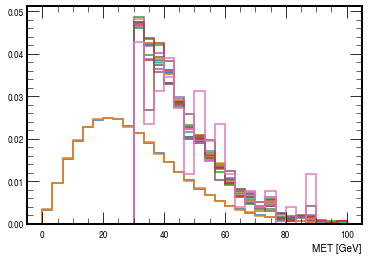

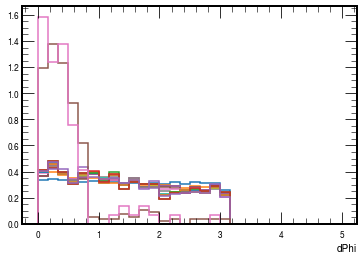

In [15]:
for cut in cuts:
    print(f"{cut}, {out['BToPhiK'][cut]};") 
    hep.histplot(out['BToPhiK'][f'{cut}_met'], density=True)
plt.show()

for cut in cuts:
    hep.histplot(out['BToPhiK'][f'{cut}_dphi'], density=True)
plt.show()

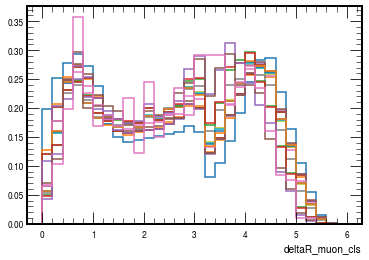

In [13]:
for cut in cuts:
    hep.histplot(out['BToPhiK'][f'{cut}_deltaR_muon_cls'], density=True)
plt.show()

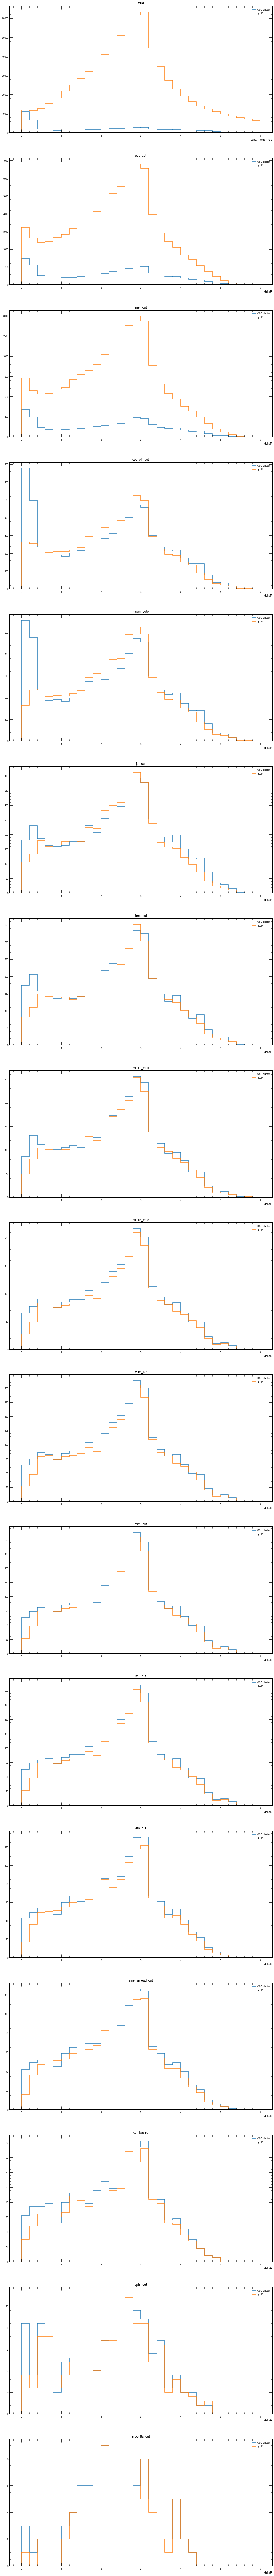

In [21]:
l = len(cuts)
fig, ax = plt.subplots(l,1, figsize = (l,l*10))

for i, cut in enumerate(cuts):
    hep.histplot(out['BToPhiK'][f'{cut}_deltaR_muon_cls'], label='CSC cluster', ax=ax[i])
    hep.histplot(out['BToPhiK'][f'{cut}_deltaR_muon_llp'], label='gLLP', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(cut)
plt.show()

In [6]:
from hist.intervals import ratio_uncertainty
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax


/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_1557/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ip

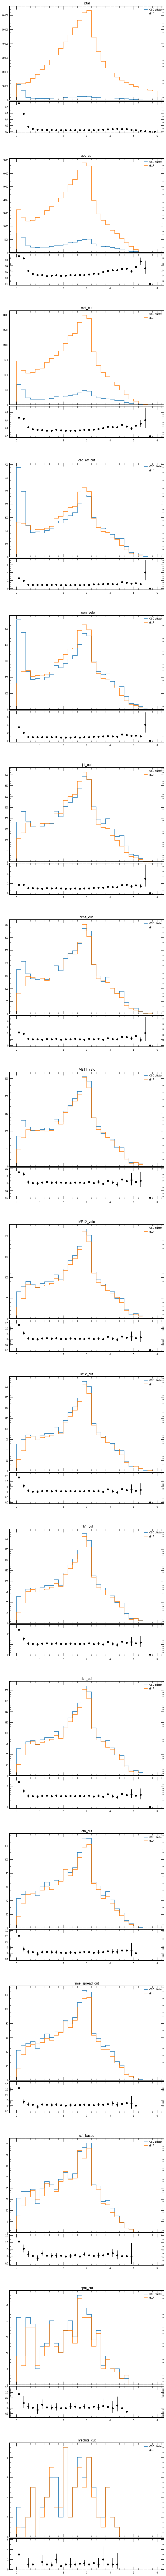

In [7]:
import matplotlib.gridspec as gridspec

l = len(cuts)
fig = plt.figure(figsize=(10, 10*l))
outer = gridspec.GridSpec(l, 1, wspace=0.2, hspace=0.2)


for i, cut in enumerate(cuts):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.02, height_ratios=[3,1])
    
    ax1 = plt.Subplot(fig, inner[0], sharex=None)
    hep.histplot(out['BToPhiK'][f'{cut}_deltaR_muon_cls'], label='CSC cluster', ax=ax1)
    hep.histplot(out['BToPhiK'][f'{cut}_deltaR_muon_llp'], label='gLLP', ax=ax1)
    ax1.set_title(cut)
    ax1.legend()
    fig.add_subplot(ax1)
    
    ax2 = plt.Subplot(fig, inner[1], sharex=None)
    num = out['BToPhiK'][f'{cut}_deltaR_muon_cls']
    den = out['BToPhiK'][f'{cut}_deltaR_muon_llp']
    ratio(num, den, ax2)
    ax2.set_xlim(ax1.get_xlim())
    fig.add_subplot(ax2)

fig.show()